In [1]:
# Imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sns
import tensorflow        as tf

from sklearn.preprocessing import StandardScaler
from tqdm.notebook         import tqdm

In [2]:
df = pd.read_csv('cab_sau_final_data.csv')
df

,ITEM_KEY,PRICE_ZONE_NAME,FISCAL_YEAR,FISCAL_WEEK,TOTAL_DISCOUNT%,SALES_QUANTITY,GIVEN_PRICE,DATE
0,102246,ABQ,2020,1,4.260000,46,10.191732,2020-01-06
1,102246,ABQ,2020,2,5.250000,47,10.374428,2020-01-13
2,102246,ABQ,2020,3,6.090000,31,10.320569,2020-01-20
3,102246,ABQ,2020,4,8.790000,58,10.023980,2020-01-27
4,102246,ABQ,2020,5,4.473333,69,10.498301,2020-02-03
...,...,...,...,...,...,...,...,...
444488,96478,Wilmington,2023,31,6.440000,7,19.237143,2023-07-31
444489,96478,Wilmington,2023,32,4.000000,5,19.190000,2023-08-07
444490,96478,Wilmington,2023,33,0.000000,2,19.990000,2023-08-14
444491,96478,Wilmington,2023,34,10.780000,2,17.835000,2023-08-21


## Data Exploration and Understanding

In [3]:
pd.isna(df).sum()

ITEM_KEY           0
PRICE_ZONE_NAME    0
FISCAL_YEAR        0
FISCAL_WEEK        0
TOTAL_DISCOUNT%    0
SALES_QUANTITY     0
GIVEN_PRICE        0
DATE               0
dtype: int64

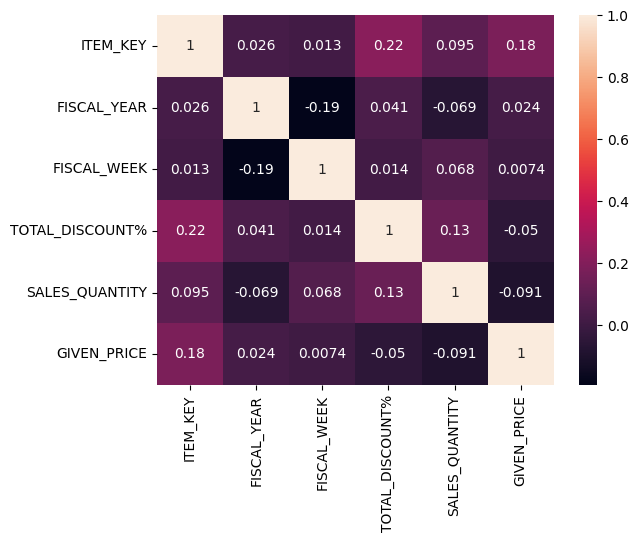

In [4]:
# Correlation heatmap
sns.heatmap(df.drop(columns=['PRICE_ZONE_NAME', 'DATE']).corr(), annot=True)
plt.show()

In [5]:
num_of_items = df['ITEM_KEY'].unique().shape[0]
print('Number of items: ', num_of_items)

num_of_zones = df['PRICE_ZONE_NAME'].unique().shape[0]
print('Number of zones: ', num_of_zones)

Number of items:  40
Number of zones:  69


## Data Preprocessing

### Seperating the categorical and time series elements

We're going to have 3 input layers for our model. Two for the categorical data, and one for the time series data.

In [6]:
df.loc[(df['ITEM_KEY'] == 102246) & (df['PRICE_ZONE_NAME'] == 'ABQ'), ['FISCAL_YEAR', 'FISCAL_WEEK']][30:]

,FISCAL_YEAR,FISCAL_WEEK
30,2020,35
31,2020,36
32,2020,37
33,2020,38
34,2020,39
...,...,...
181,2023,31
182,2023,32
183,2023,33
184,2023,34


In [7]:
def preprocess(df, scaler, window_size=30, return_date=False):
    """
    Sorts the dataframe by FISCAL_YEAR and FISCAL_WEEK, normalizes SALES_QUANTITY, and stores the last 30 weeks of data for each item in each zone.
    """

    # Sort df by FISCAL YEAR and FISCAL WEEK
    df = df.sort_values(by=['FISCAL_YEAR', 'FISCAL_WEEK'])

    # Normalize SALES_QUANTITY
    df['SALES_QUANTITY'] = scaler.fit_transform(df['SALES_QUANTITY'].values.reshape(-1, 1)).flatten()

    # Store the last 30 weeks of data for each item in each zone
    windowed_data = []
    dates = pd.DataFrame(columns=['FISCAL_YEAR', 'FISCAL_WEEK'])
    y = []

    for item in tqdm(df['ITEM_KEY'].unique()):
        for zone in df['PRICE_ZONE_NAME'].unique():
            # Temporary df for each item in each zone
            sq = df.loc[(df['ITEM_KEY'] == item) & (df['PRICE_ZONE_NAME'] == zone), 'SALES_QUANTITY']

            length = df.loc[(df['ITEM_KEY'] == item) & (df['PRICE_ZONE_NAME'] == zone)].shape[0]

            if length == 0:
                continue
            
            # If there are less than 30 weeks of data, fill with 0s
            if length < window_size:
                # Make one row filling with 0s for missing weeks
                row = [item, zone]
                row.extend(np.zeros(window_size-length))
                row.extend(sq.values.tolist()[:(length-1)])
                windowed_data.append(row)
                y.append(sq.values.tolist()[-1])

            # Return dates for each item in each zone
            if return_date:
                new_dates = df.loc[(df['ITEM_KEY'] == item) & (df['PRICE_ZONE_NAME'] == zone), ['FISCAL_YEAR', 'FISCAL_WEEK']][window_size:]
                dates = pd.concat([dates, new_dates], ignore_index=True, sort=False)

            # Create windowed data
            for i in range(window_size, len(sq)):
                # X
                row = [item, zone]
                row.extend(sq[i-window_size:i-1].values.tolist())
                windowed_data.append(row)

                # y
                y.append(sq.values[i])

    # Create column names
    col_names = ['ITEM_KEY', 'PRICE_ZONE_NAME']
    for i in range(window_size-1, 0, -1):
        col_names.append('t-' + str(i))

    if return_date:
        return pd.DataFrame(pd.concat([dates, pd.DataFrame(windowed_data, columns=col_names)], axis=1)), pd.Series(y)

    return pd.DataFrame(windowed_data, columns=col_names), pd.Series(y)

In [8]:
window_size = 30
scaler = StandardScaler()
X, y = preprocess(df, scaler, window_size, True)

  0%|          | 0/40 [00:00<?, ?it/s]

In [9]:
X.columns

Index(['FISCAL_YEAR', 'FISCAL_WEEK', 'ITEM_KEY', 'PRICE_ZONE_NAME', 't-29',
       't-28', 't-27', 't-26', 't-25', 't-24', 't-23', 't-22', 't-21', 't-20',
       't-19', 't-18', 't-17', 't-16', 't-15', 't-14', 't-13', 't-12', 't-11',
       't-10', 't-9', 't-8', 't-7', 't-6', 't-5', 't-4', 't-3', 't-2', 't-1'],
      dtype='object')

In [39]:
def train_test_split(X, y, test_size=0.05):
    X_copy = pd.get_dummies(X, columns=['ITEM_KEY', 'PRICE_ZONE_NAME'])

    X_train_pzn = []
    X_test_pzn  = []
    X_train, X_test, y_train, y_test = None, None, None, None
    
    for item in X['ITEM_KEY'].unique():
        for zone in X['PRICE_ZONE_NAME'].unique():
            X_temp = X_copy.loc[(X['ITEM_KEY'] == item) & (X['PRICE_ZONE_NAME'] == zone)]
            y_temp = y.loc[(X['ITEM_KEY'] == item) & (X['PRICE_ZONE_NAME'] == zone)]
            
            split_index = int(round(len(X_temp) * (1 - test_size), 0))
            
            if X_train is None:
                X_train_pzn.extend([zone] * X_temp.iloc[:split_index].shape[0])
                X_test_pzn.extend([zone] * X_temp.iloc[split_index:].shape[0])
                X_train = X_temp.iloc[:split_index,]
                X_test  = X_temp.iloc[split_index:,]
                y_train = y_temp.iloc[:split_index]
                y_test  = y_temp.iloc[split_index:]
                continue

            X_train_pzn.extend([zone] * X_temp.iloc[:split_index].shape[0])
            X_test_pzn.extend([zone] * X_temp.iloc[split_index:].shape[0])
            X_train = pd.concat([X_train, X_temp.iloc[:split_index]])
            X_test  = pd.concat([X_test, X_temp.iloc[split_index:]])
            y_train = pd.concat([y_train, y_temp.iloc[:split_index]])
            y_test  = pd.concat([y_test, y_temp.iloc[split_index:]])

    return X_train, X_test, y_train, y_test, X_train_pzn, X_test_pzn

In [40]:
X_train, X_test, y_train, y_test, X_train_pzn, X_test_pzn = train_test_split(X, y)

X_train_misc = X_train[['FISCAL_YEAR', 'FISCAL_WEEK']]
X_test_misc  = X_test[['FISCAL_YEAR', 'FISCAL_WEEK']]

X_train.drop(columns = ['FISCAL_YEAR', 'FISCAL_WEEK'], inplace=True)
X_test.drop(columns  = ['FISCAL_YEAR', 'FISCAL_WEEK'], inplace=True)

In [41]:
rearrange_col = X_train.columns[29:].tolist()
rearrange_col.extend(X_train.columns[:29].tolist())

In [42]:
X_train = X_train[rearrange_col]
X_test  = X_test[rearrange_col]

In [14]:
num_of_items = 0
num_of_zones = 0

for col_name in np.array(X_train.columns):
    if 'ITEM_KEY' in col_name:
        num_of_items += 1
    elif 'PRICE_ZONE_NAME' in col_name:
        num_of_zones += 1

print('Number of items: ', num_of_items)
print('Number of zones: ', num_of_zones)

Number of items:  40
Number of zones:  69


## Model

### Model Design

In [66]:
from keras.models import Model, Sequential
from keras.layers import Input, Embedding, GRU, Dense, Dropout, Reshape, concatenate

# Define the input layers
item_input = Input(shape=(num_of_items,), name='item_key_input')
zone_input = Input(shape=(num_of_zones,), name='zone_name_input')
ts_input = Input(shape=(window_size-1,), name='ts_input')

# Dense layer for categorical features
d1 = Dense(units=32, activation='relu', name='item_dense_1')(item_input)
d2 = Dense(units=64, activation='relu', name='zone_dense_1')(zone_input)

# Reshape ts_input for GRU layer
ts_input = Reshape((window_size-1, 1))(ts_input)

# GRU layer for time series data
ts_gru = GRU(units=64, dropout=0.3, return_sequences=True, name='ts_gru')(ts_input)
ts_gru = GRU(units=32, dropout=0.2, return_sequences = True, name='ts_gru2')(ts_gru)
ts_gru = GRU(units=16, dropout=0.1, name='ts_gru3')(ts_gru)

# Concatenate the outputs of the embedding layers and GRU layer
concatenated = concatenate([d1, d2, ts_gru], name='concatenated')

# Dense layers for the rest of your model
x = Dense(256, activation='relu')(concatenated)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.1)(x)
x = Dense(16, activation='relu')(x)
output = Dense(1, activation='linear')(x)

# Create the model
model = Model(inputs=[item_input, zone_input, ts_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [67]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 29, 1)]      0           []                               
                                                                                                  
 ts_gru (GRU)                   (None, 29, 64)       12864       ['input_3[0][0]']                
                                                                                                  
 item_key_input (InputLayer)    [(None, 40)]         0           []                               
                                                                                                  
 zone_name_input (InputLayer)   [(None, 69)]         0           []                               
                                                                                            

### Model Training

In [68]:
# Early Stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.01,
    mode='min',
    restore_best_weights=True
)

model.fit(
    [X_train.iloc[:,:40], X_train.iloc[:,40:109], X_train.iloc[:,109:]],
    y_train,
    batch_size=32,
    epochs=15,
    callbacks=[early_stopping],
    validation_split=0.1,
)

Epoch 1/15
9762/9762 [==============================] - 173s 17ms/step - loss: 0.2653 - mse: 0.2653 - mae: 0.2499 - val_loss: 0.2581 - val_mse: 0.2581 - val_mae: 0.2518
Epoch 2/15
9762/9762 [==============================] - 171s 17ms/step - loss: 0.2371 - mse: 0.2371 - mae: 0.2359 - val_loss: 0.2636 - val_mse: 0.2636 - val_mae: 0.2663
Epoch 3/15
9762/9762 [==============================] - 168s 17ms/step - loss: 0.2309 - mse: 0.2309 - mae: 0.2332 - val_loss: 0.2891 - val_mse: 0.2891 - val_mae: 0.2921
Epoch 4/15
9762/9762 [==============================] - 170s 17ms/step - loss: 0.2239 - mse: 0.2239 - mae: 0.2303 - val_loss: 0.2800 - val_mse: 0.2800 - val_mae: 0.2989
Epoch 5/15
9762/9762 [==============================] - 168s 17ms/step - loss: 0.2171 - mse: 0.2171 - mae: 0.2276 - val_loss: 0.2995 - val_mse: 0.2995 - val_mae: 0.3300
Epoch 6/15
9762/9762 [==============================] - 169s 17ms/step - loss: 0.2149 - mse: 0.2149 - mae: 0.2275 - val_loss: 0.3212 - val_mse: 0.3212 - va

In [69]:
# Save the model
model.save('model.h5')

### Evaluation and Visualization

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras

model = keras.models.load_model('model.h5')

# MSE and MAE on the training set
y_pred = model.predict([X_train.iloc[:,:40], X_train.iloc[:,40:109], X_train.iloc[:,109:]])
print('MSE on the training set: ', mean_squared_error(y_train, y_pred))
print('MAE on the training set: ', mean_absolute_error(y_train, y_pred))

# MSE and MAE on the test set
y_pred = model.predict([X_test.iloc[:,:40], X_test.iloc[:,40:109], X_test.iloc[:,109:]])
print('MSE on the test set: ', mean_squared_error(y_test, y_pred))
print('MAE on the test set: ', mean_absolute_error(y_test, y_pred))

10847/10847 [==============================] - 99s 8ms/step
MSE on the training set:  0.24465755624061938
MAE on the training set:  0.23068285826094997
569/569 [==============================] - 5s 8ms/step
MSE on the test set:  0.06701267078172471
MAE on the test set:  0.15286933707901293


In [17]:
# Transform back
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test.values.reshape(-1, 1))

y_pred = y_pred.flatten()
y_test = y_test.flatten()

In [77]:
plot_df = pd.DataFrame(np.array([y_pred, y_test, X_test_pzn]).T, columns=['Predicted', 'Actual', 'Zone'])
plot_df['FISCAL_YEAR'] = X_test_misc['FISCAL_YEAR'].values
plot_df['FISCAL_WEEK'] = X_test_misc['FISCAL_WEEK'].values
plot_df.dropna(inplace=True)

In [78]:
from datetime import datetime, timedelta

def get_date(year, week):
    return datetime.strptime(f'{year} {week} 1', "%Y %W %w")

plot_df['Date'] = [get_date(year, week) for year, week in zip(plot_df['FISCAL_YEAR'], plot_df['FISCAL_WEEK'])]
plot_df

,Predicted,Actual,Zone,FISCAL_YEAR,FISCAL_WEEK,Date
0,31.302952,-0.4936031810794344,ABQ,2023,28,2023-07-10
1,31.183952,-0.5085316725775999,ABQ,2023,29,2023-07-17
2,30.800896,-0.4040322320904409,ABQ,2023,30,2023-07-24
3,30.348518,-0.5906383758175107,ABQ,2023,31,2023-07-31
4,30.424587,-0.44135346083585486,ABQ,2023,32,2023-08-07
...,...,...,...,...,...,...
18186,49.918144,-0.366711003345027,San Diego,2023,19,2023-05-08
18187,48.505844,-0.28460430010511634,San Diego,2023,20,2023-05-15
18188,47.49064,-0.18010485961795733,San Diego,2023,21,2023-05-22
18189,16.294163,-0.5831741300684278,Pensacola,2023,29,2023-07-17


In [80]:
plot_df.sort_values(by='Date', inplace=True)

,Predicted,Actual,Zone,FISCAL_YEAR,FISCAL_WEEK,Date
1039,144.81668,0.4767487663013279,Delaware,2020,31,2020-08-03
1055,102.405205,-0.04574843613446717,EGH/303,2020,31,2020-08-03
1047,98.090645,-0.13531938512346062,Denver,2020,31,2020-08-03
1031,28.820297,-0.5010674268285171,Daytona,2020,31,2020-08-03
1023,402.89615,1.1858521124641928,Dallas,2020,31,2020-08-03
...,...,...,...,...,...,...
1512,101.83512,0.07367949585085742,EGH/303,2023,35,2023-08-28
1504,97.89644,0.11846497034535414,Denver,2023,35,2023-08-28
1496,314.40384,3.1340202529748002,Delaware,2023,35,2023-08-28
1488,26.508144,-0.5085316725775999,Daytona,2023,35,2023-08-28


In [86]:
import plotly.express as px

fig = px.line(plot_df.loc[plot_df['Zone'].isin(plot_df['Zone'].unique()[:5])], x='Date', y='Predicted', color='Zone', title='Predicted vs Actual Sales Quantity')
fig.show()

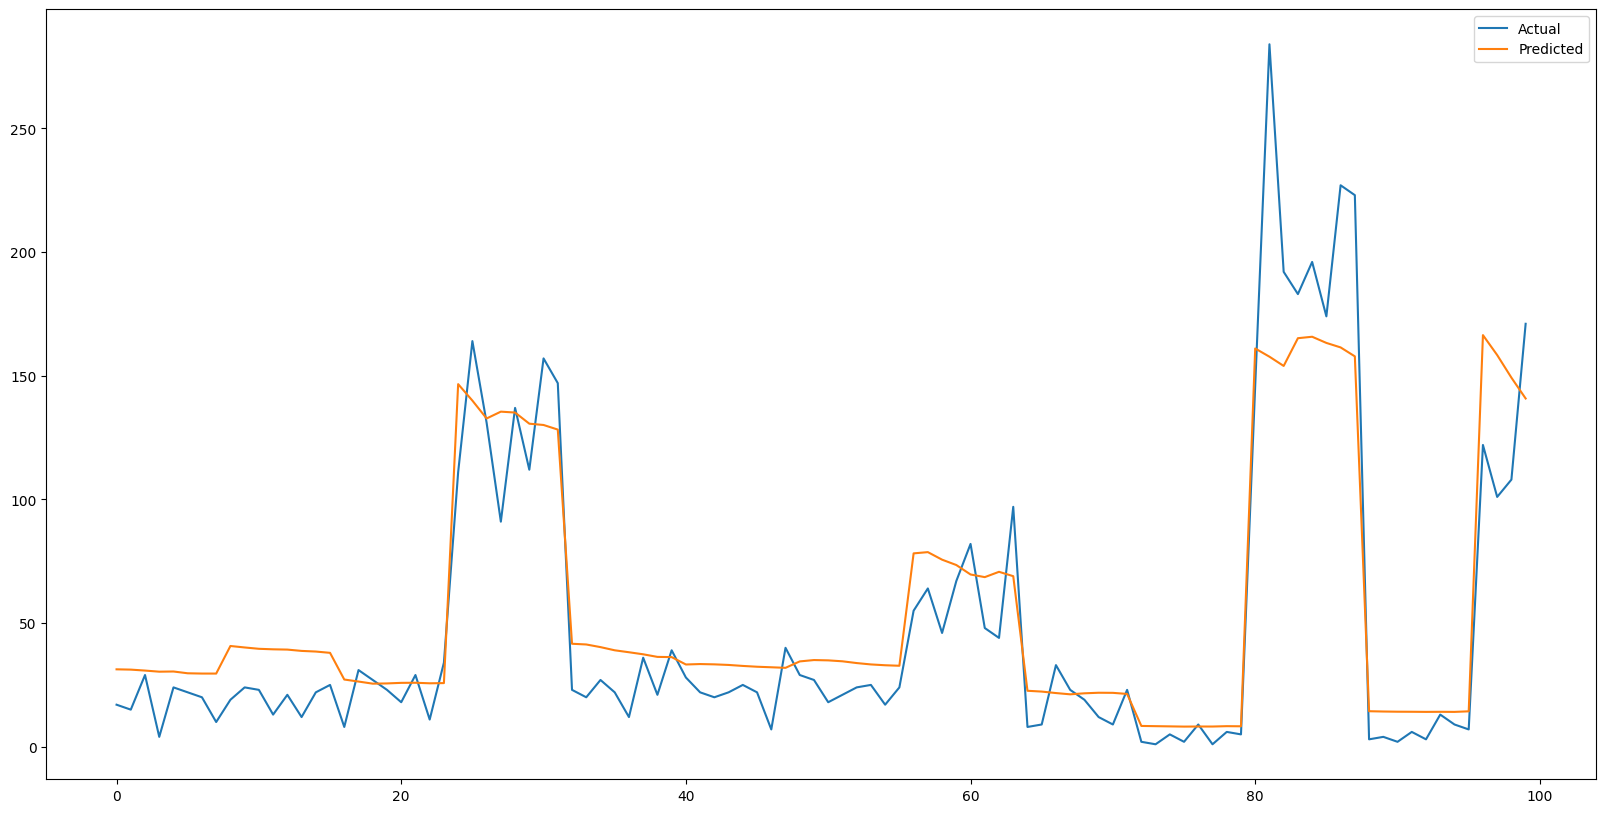

In [24]:
# Visualisation of predictions vs actual values
plt.figure(figsize=(20, 10))
plt.plot(y_test[:100], label='Actual')
plt.plot(y_pred[:100], label='Predicted')
plt.legend()
plt.show()